__W207 Final Project, Fall 2016__   
__Facial Keypoints Challenge__  
__Team:__ Matt Swan, Guillaume De Roo, Stanley Opara, Maya Miller-Vedam

# Final Submission


__OVERVIEW:__ This notebook contains our implementation and development proccess for a convolutional neural net solution to the [Kaggle Facial Keypoint Detection Challenge](https://www.kaggle.com/c/facial-keypoints-detection). 

_Although a full list of citations is included at the end we'd like to acknowledge here at the top our debt to the ideas and lessons presented in_ [this tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) _authored by Daniel Nouri and made available on the Kaggle competition website. Although all of the net architectures below are our own, we have used some of D. Nouri's code for data loading and augmenations (as noted in docstrings)_.

__IN ADDITION:__ Due to the time necessary to train some of the neural networks. We will not show here the final results, which we will finish and submit to Kaggle ahead of the final presentation.

## CONTENTS
1. Set up
    1. Imports
    1. Helper Functions
    1. Data Loading & Global Vars
1. Introduction
    1. Exploration
    1. Naive Prediction
    1. First Neural Network
1. Exploring Different Architectures
    1. Inital Improvements
    1. Net Depth
1. Training Specialists
    1. Introducing Specialists
    1. Correction of Overfitting
1. Citations
1. Appendix

## Set Up

<font color='red'>WARNING: We do not recommend trying to run the code below onto a laptop. To train the models below, the group created a special AMI with GPUs. </font>

NOTE: this notebook expects that you are running Python 2.7 with Theano configured to run on a GPU and that you have the data loaded in a directory called __'Data'__ within the current directory. If your set up doesn't meet these requirements you may need to make slight modifications to the import statements and data loading code below.

### A. Imports

In [1]:
# General Imports
import os
import sys
import time
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as pyplot

%matplotlib inline

# If you are not on Python 3, uncomment the line below
import cPickle as pickle
# If you are on Python 3, use the command below
#import pickle

In [2]:
# ML related imports
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

# importing lasagne, neural net algorithms
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import PrintLayerInfo
import theano

In [3]:
# We need to increase the recursion limit for python to run pickle
sys.setrecursionlimit(10000)

### B. Helper Functions

In [4]:
# loading function
def load(test=False, cols=None, rows=None):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns or pass an integer to *rows* to load only a subset of
    the full data set. 
    
    NOTE: this function drops rows with missing values.
    
    This function is modified from code provided D. Nouri's tutorial.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        if rows is not None:
            X, y = X[0:rows,], y[0:rows,]
    else:
        if rows is not None:
            X = X[0:rows,]
        y = None

    return X,y

In [5]:
# 2D loading function
def load2d(test=False, cols=None, rows = None):
    """
    Wrapper function to load and tranform the data into a 2D format.
    This function is modified from code provided D. Nouri's tutorial.
    """
    X, y = load(test=test, cols=None, rows = None)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [19]:
# Function to convert normalized validation/train loss to RMSE
def RMSE(loss):
    """
    Function to take MSE loss from data scaled to [-1 , 1] 
    and convert it back to the original scale [0,96].
    """
    return np.sqrt(loss) * 48

In [7]:
# function to plot train loss vs validation loss for multiple nets
def plot_loss(nets, window=None):
    """
    Function to plot comparison of training loss and validation loss
    for a list of nets (that have already been trained). Optional
    window parameter should be a list [xmin, xmax, ymin, ymax].
    NOTE: the input should be a list of strings corresponding to 
    nets that have been initialized in the current namespace.
    
    This function is modified from code provided D. Nouri's tutorial.
    """
    fig, axes = pyplot.subplots(figsize=(10,6))
    axes.set_color_cycle(
        ['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

    for net_name in nets:
        net = globals()[net_name]
        epochs = np.array([i['epoch'] for i in net.train_history_])
        valid_loss = np.array([i['valid_loss'] for i in net.train_history_])
        train_loss = np.array([i['train_loss'] for i in net.train_history_])
        valid_loss = RMSE(valid_loss)
        train_loss = RMSE(train_loss)
        axes.plot(valid_loss, linewidth=1,
                  label = '%s validation loss'%(net_name))
        axes.plot(train_loss, linestyle='--', linewidth=1, alpha=0.6,
                 label = '%s training loss'%(net_name))
    if window:    
        pyplot.axis(window)
    pyplot.ylabel("RMSE")
    pyplot.xlabel("Epochs")
    pyplot.legend(loc='center left', bbox_to_anchor=(1,0.5))
    pyplot.show()

### C. Global Variables

In [11]:
# Training and test data paths
FTRAIN = '/home/ubuntu/data/training.csv'
FTEST = '/home/ubuntu/data/test.csv'

For some of the code below we rely on saved versions of neural nets that have already been trained. The code to create and train these nets is available in the supplementary materials submitted with our project (_architectures.py_ and _deeper_nets.py_). You can download these nets to your current directory using the following commands:
* `wget https://s3.amazonaws.com/w207proj/net71.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/net2.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/net5.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/base_net.pickle`
* `wget https://s3.amazonaws.com/w207finalprojet/cnn0.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/cnn1.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/cnn2.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/cnn3.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/cnn4.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/cnn5.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/cnn6_10k.pickle`
* `wget https://s3.amazonaws.com/w207finalproject/cnn7_6k.pickle`

Update the following path to match the location of these files:

In [9]:
# File Paths to saved neural nets (.pickle files)
FNETS = '/home/ubuntu/W207_FinalProject/Our_Nets/'

## 2. Introduction to Facial Keypoints

### A. Exploration

In this section, we do a quick exploratory tour of the data to increase familiarity of the reader and highlight some important features of the Kaggle dataset which will be useful later on.

To get a first sense of the data, we can load it using the *load2d* function

In [12]:
# Loading the dataset and printing the dimensions of the selected set
X, y = load2d()
print("Dimensions X:", X.shape)
print("Dimensions y:", y.shape)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

For each image, we can see that there are up to 15 point x 2 coordinates = 30 parameters that we need to predict.

We can see that even though there are 7049 images, we do not have the values of all facial key points for these images, in fact there are only 2140 complete examples in the dataset. We can note however that not all features are in that situation: for example, the center of the eyes, the nose tip, and the bottom center of the mouth all have about 7000 data points. This a characteristic that we will exploit later, in the section on specialist neural networks

In [16]:
def plot_sample(X, y, nb):
    """
    Function to plot a sample of images along with a series of given or predicted features
    """
    def subplotting(x, y, axis):
        axis.imshow(x, cmap='gray')
        axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

    fig = pyplot.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    i_list = np.random.choice(X.shape[0], nb, replace = False) # creates a random set of indices
    
    for i in range(nb):
        l = np.ceil(np.sqrt(nb))
        ax = fig.add_subplot(l, l, i + 1, xticks=[], yticks=[])
        subplotting(X[i_list[i]][0], y[i_list[i]], ax)

    pyplot.show()

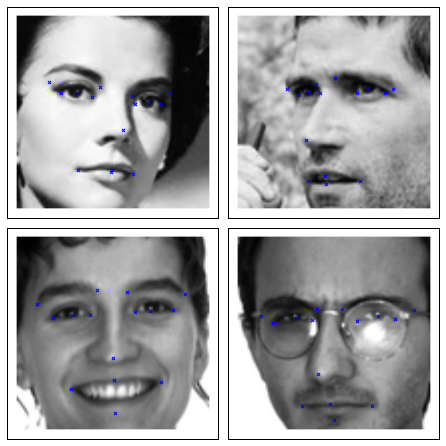

In [11]:
# We plot 4 images
plot_sample(X, y, 4)

There is some intrinsic imprecision in the dataset labelling, which will make predictions complicated. For example, if we run the previous algorithm a couple of times, we can see that the bottom and top of the mouth correspond sometimes to the inner and sometimes outer limit of the lips.

### B. Naive Prediction

We can build a naive prediction, by simply doing an average of the coordinates of the different points of interest:

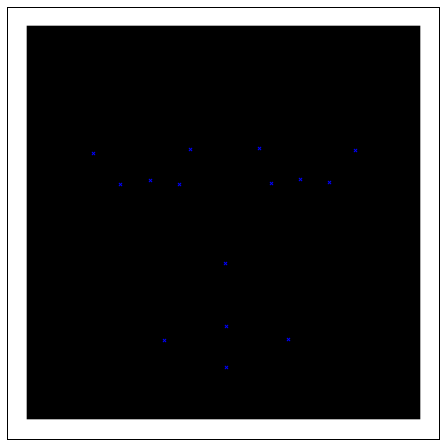

In [17]:
# Calculate Naive (average) prediction RMSE as a base
y_naive = np.mean(y, axis = 0).reshape(1,30)
blank = np.array([np.array([np.zeros((96,96))])])
plot_sample(blank,y_naive,1)

We now calculate the RMSE between this Naive prediction and the training set (here we merely want to illustrate the orders of magnitude, but ideally, we would do that calcualtion by using cross validation)

In [33]:
loss = np.sum((y-y_naive)**2 / y.shape[0])
print('Loss:', loss)
print('RMSE:', RMSE(loss))

Loss: 0.132052
RMSE: 17.4427227974


### C. First Neural Network

We create a simple neural network which serves as a starting point for our future improvements

In [47]:
cnn0 = NeuralNet(
                 layers=[
                         (layers.InputLayer, {'shape': (None, 1, 96, 96)}),
                         (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
                         (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
                         (layers.DenseLayer, {'num_units': 100}),
                         (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
                         ],
                 
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,
                 max_epochs= 10,
                 verbose=1,
                 )

# Neural Network with 55365306 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input0   1x96x96
  1  conv2d1  32x94x94
  2  conv2d2  64x93x93
  3  dense3   100
  4  dense4   30


In [17]:
# load trained net
with open(FNETS + "cnn0.pickle", 'rb') as f:
    cnn0 = pickle.load(f)

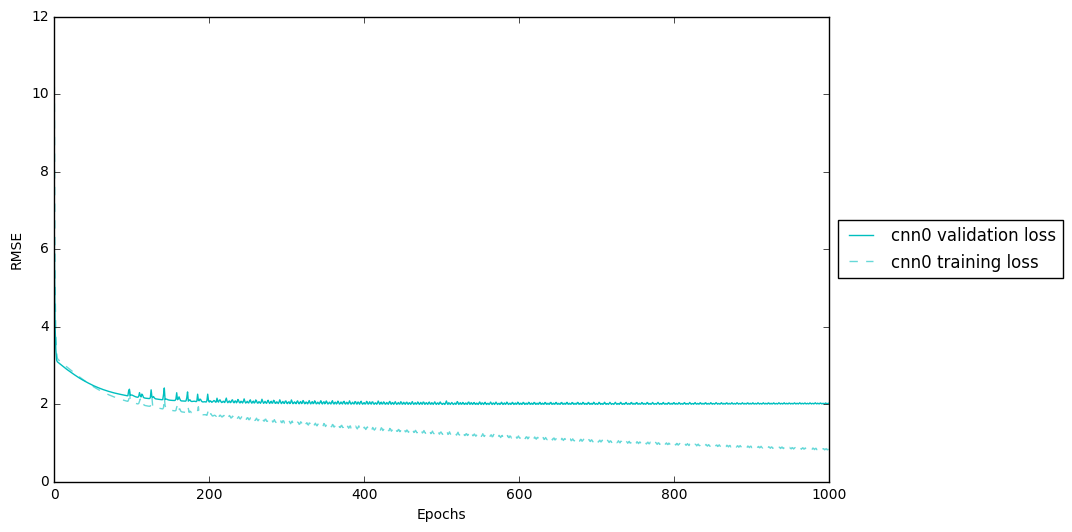

In [18]:
# take a look
plot_loss(['cnn0'])

## 3. Exploring Different Architectures

Although the initial convolutional net we saw above was a significant improvement over the "naive" prediction, it has a number of weaknesses. In particular, the net is significantly overfitting the data so we'll want to add some regularization. In this section we'll discuss some ways in which we can modify our net architecture to improve its performance.

### A. Initial Improvements: Pooling Layers, Dropout and the FlipBatchIterator

One of the conditions that can lead to overfitting is when the neural net architecture has to learn all of its paramters from a comparatively small set of training examples. As you saw in the loading code we have initially limited our training set to the 2270 cases which include values for all 30 labels. In a later section we'll discuss ways to take advantage of the discarded data but there are a number of improvments we can make in the meantime. 

In his tutorial Daniel Nouri modeled three core techniques for improving a net's ability to learn given a small training set: __pooling layers__, __dropout__ and adding variance to the training set by __flipping images at random__ during the backpropagation process.

Pooling layers help us avoid overfitting simply by reducing the representation of the data (and therefore reducing the number of parameters in our subsequent convolution layers). In neural net terminology we'd say that pooling layers increase the _learning capacity_ of the net, although too much pooling can increase the _coverage_ of the net beyond desirable levels. (see Benjamin Bossan's tutorial listed in our citations for a more indepth discussion of this topic).

Dropout is also a regularization technique but instead of alterning the net architecture it instead alters the way that the backpropagation algorithm operates. Specifically adding dropout instructs the net to ignore a specified percentage of the nodes (that are then randomly chosen each epoch) when estimating the loss function. This prevents nodes from learning similar features.

Finally, Daniel Nouri's FlipBatchIterator class randomly flip 50% of the training images each epoch which increases the variablity of the data informing the weights of our net without increasing the training size (or using more space in memory).

To illustrate the effect of these three techniques lets look at another neural net. Below __cnn1__ has three convolutional layers and two dense layers. Each convolutional layer is followed by a pooling layer and all layers are followed by dropout (set to 50%).

In [ ]:
cnn1 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),


        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

To see how this new net performes compared to the initial net we'll plot the training and validation loss for each:

In [20]:
# load trained nets
with open(FNETS + "cnn1.pickle", 'rb') as f:
    cnn1 = pickle.load(f)    

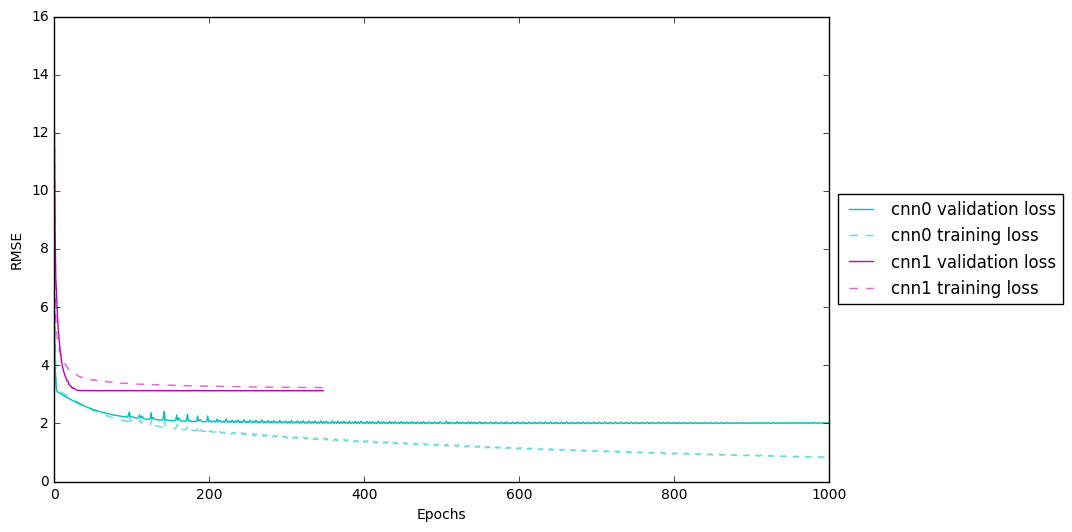

In [38]:
# take a look
plot_loss(['cnn0', 'cnn1'])

Suprisingly, (or maybe not so suprisingly) simply adding pooling and dropout layers did not improve the performance of the net. In fact the new net performs so much worse that it stops early due to so little improvement in the validation loss.

This speaks to the recurring theme in lots of tutorials that finding the right architecture is a balance of art and science. At this point, as far as we can tell, the worse performance might indicate a bad architecture but might also simply indicate that we need to better tune the parameters for the net. One idea is to take a closer look at the differences between these architectures by calculating their respective coverage and capacity and thinking more carefully about the number of parameters introduced at each stage of the net.

In [29]:
# print architecture detailse for cnn0 and cnn1
showLayers = PrintLayerInfo()
cnn0.verbose = 2
showLayers(cnn0)
cnn1.verbose = 2
showLayers(cnn1)

# Neural Network with 55365306 learnable parameters

## Layer information

name     size        total    cap.Y    cap.X    cov.Y    cov.X
-------  --------  -------  -------  -------  -------  -------
input0   1x96x96      9216   100.00   100.00   100.00   100.00
conv2d1  32x94x94   282752   100.00   100.00     3.12     3.12
conv2d2  64x93x93   553536    50.00    50.00     4.17     4.17
dense3   100           100   100.00   100.00   100.00   100.00
dense4   30             30   100.00   100.00   100.00   100.00

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    image coverage too high (>100%)
    red:     capacity too low and coverage too high


# Neural Network with 16561502 learnable parameters

## Layer information

name        size         total    cap.Y    cap.X    cov.Y    cov.X
----------  ---------  -------  -------  -------  -------  -------
input0      1x96x96       9216   1

### B. Net Depth

Another common theme in Deep Learning is the idea that "Deeper is Better." However as we saw in the first example, this is clearly not always true... or at least not 'simply' true. Deeper nets come with obvious trade offs: they are harder to train and get large quite quickly. However if tuned appropriately they should often yield better results. Hoping to explain the supprising worse performance of cnn1 we decided to try a few different deeper architectures to see if there is a convincing trend in the effect of net depth on the predictive power for our data. 

Below we take a look at how the performance of our five layer (2 convolution) net from above compares to two similar but deeper nets. The first, cnn2 is identical to cnn1 except that it has two convolutional layers where cnn0 has 1. The second, cnn3 has three convolutional layers in place of each of cnn0's one. Let's take a look:

In [30]:
# load trained nets
with open(FNETS + "cnn2.pickle", 'rb') as f:
    cnn2 = pickle.load(f)
with open(FNETS + "cnn3.pickle", 'rb') as f:
    cnn3 = pickle.load(f)   

In [31]:
# print architecture detailse for cnn2 and cnn3
showLayers = PrintLayerInfo()
cnn2.verbose = 2
showLayers(cnn2)
cnn3.verbose = 2
showLayers(cnn3)

# Neural Network with 13964862 learnable parameters

## Layer information

name         size         total    cap.Y    cap.X    cov.Y    cov.X
-----------  ---------  -------  -------  -------  -------  -------
input0       1x96x96       9216   100.00   100.00   100.00   100.00
conv2d1      32x94x94    282752   100.00   100.00     3.12     3.12
conv2d2      32x92x92    270848    60.00    60.00     5.21     5.21
maxpool2d3   32x46x46     67712    60.00    60.00     5.21     5.21
dropout4     32x46x46     67712   100.00   100.00   100.00   100.00
conv2d5      64x45x45    129600   100.00   100.00   100.00   100.00
conv2d6      64x44x44    123904   100.00   100.00   100.00   100.00
maxpool2d7   64x22x22     30976   100.00   100.00   100.00   100.00
dropout8     64x22x22     30976   100.00   100.00   100.00   100.00
conv2d9      128x21x21    56448   100.00   100.00   100.00   100.00
conv2d10     128x20x20    51200   100.00   100.00   100.00   100.00
maxpool2d11  128x10x10    12800   100.00 

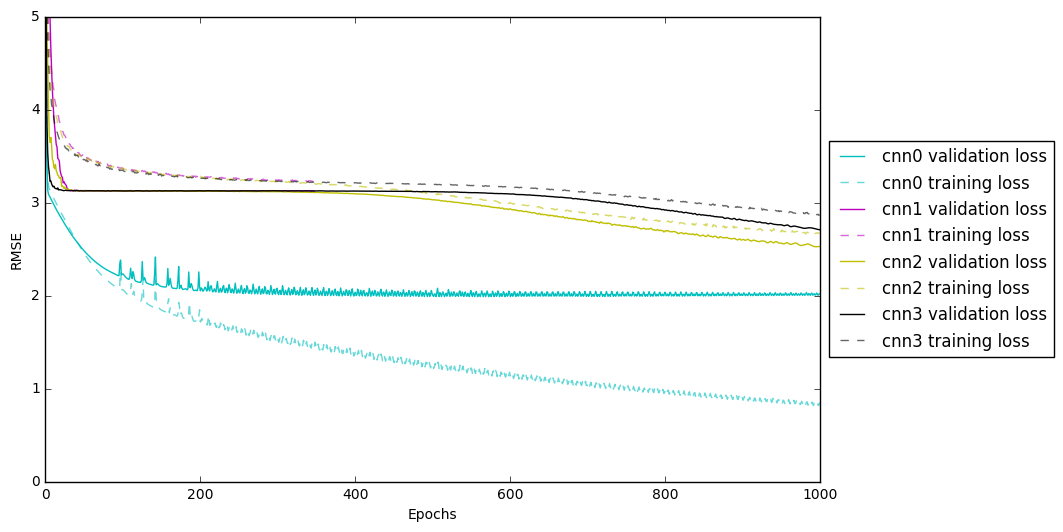

In [39]:
# plot performance
plot_loss(['cnn0', 'cnn1','cnn2', 'cnn3'], window=[0,1000, 0,5])

We can see from this plot that the nets with doubled and trippled convolutions has the same initial slow down in performance but they then start to improve again. This suggests that a longer train time might give a better perspective on the merit of deeper architectures. This also makes sense given that the more layers a net has the more parameters to train and the longer it will take to train the net as a whole. 

At this point, hesitant about the long train times we tried a few other things: larger filters, more/less filters, more/less dense layers. None had any significant effect worth mentioning (although we were only training to 1000 epochs so in hindsight the last may be worth revisiting). 

However one small change we tried did make a big difference: removing the dropout layer following the final dense layer. As with so many things we tried in retrospect this makes a lot of sense. The effect of dropout is (in layman's "hand-wavy" terms) to randomly prevent some nodes from participating in the net (and therefore receiving the feedback that backpropagates from the error in latter layers). We really don't want to do that between the final dense layer and the output because we need as much information (about sources of error) as we can get to spread back into earlier layers.

This brings us to the next set of nets based on cnn1 cnn2 and cnn3 but without that last dropout layers. In these nets we also make two key additional choices: we reduced the dropout layer percents (since clearly the models above are not overfitting, infact they're underfitting) and we trained for many more epochs. Here's what we saw:

In [43]:
# load trained nets
with open(FNETS + "base_net.pickle", 'rb') as f:
    base_net = pickle.load(f) # This was D. Nouri's net7
with open(FNETS + "cnn6_10k.pickle", 'rb') as f:
    cnn6 = pickle.load(f) 
with open(FNETS + "cnn7_6k.pickle", 'rb') as f:
    cnn7 = pickle.load(f) 

In [44]:
# print architecture details for cnn6 and cnn7
showLayers(base_net)
showLayers(cnn6)
showLayers(cnn7)

# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    30

# Neural Network with 13964862 learnable parameters

## Layer information

  #  name         size
---  -----------  ---------
  0  input0       1x96x96
  1  conv2d1      32x94x94
  2  conv2d2      32x92x92
  3  maxpool2d3   32x46x46
  4  dropout4     32x46x46
  5  conv2d5      64x45x45
  6  conv2d6      64x44x44
  7  maxpool2d7   64x22x22
  8  dropout8     64x22x22
  9  conv2d9      128x21x21
 10  conv2d10     128x20x20
 11  maxpool2d11  128x10x10
 12  dropout12    128x10x10
 13  dense13      1000
 14  dropout14    1000
 15  dense15      1000
 16  dense

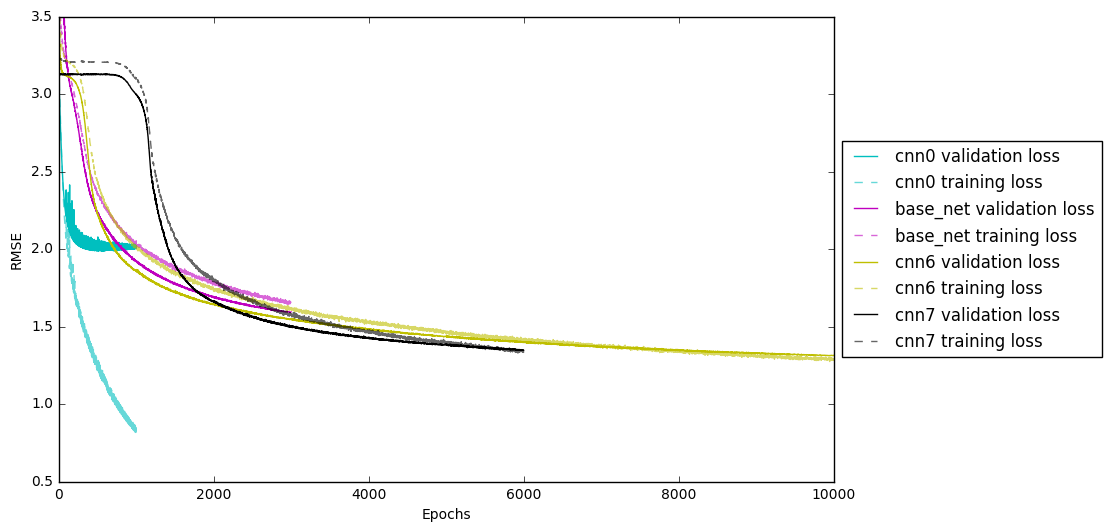

In [49]:
# take a look
plot_loss(['cnn0','base_net', 'cnn6', 'cnn7'], window = [0,10000,0.5,3.5])

That looks a lot better! We've finally got our deeper architectures performing significantly better than the original 'simple' convolutional net. Also note that our nets are not overfitting at all... infact for the deeper architectures it takes upwards of 7000 epochs for the training loss to (roughly) equal (and then beat) the validation loss.

Note that the different stopping points are the result of pre-training different nets for different lengths of time. In fact the base net if trained for 10k also approaches the validation loss that we see in cnn6 and cnn7 however the latter two are a bit better. Presumably cnn7 would continue to improve further however even on a CUDA optimized GPU it takes 8 seconds per epoch so its a question of whether the small improvement is worth the extra time.

As a final step before looking at improvements to specific keypoints we can look calculate the RMSE for our two best nets: cnn6 and cnn7 to get a sense for how we might score on the Kaggle Competition.

In [55]:
# Compare RMSE:
print RMSE(cnn6.train_history_[-1]['valid_loss'])
print RMSE(cnn7.train_history_[-1]['valid_loss'])

1.3135099121
1.3461054757


In later sections we'll reuse these net architectures:

In [ ]:
cnn6 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),

        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.1}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.2}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.3}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=400),
        ],
    max_epochs=1000,
    verbose=1,
    )

In [ ]:
cnn7 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),

        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.1}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.2}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.3}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.95)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.95, stop=0.999),
        EarlyStopping(patience=400),
        ],
    max_epochs=500,
    verbose=1,
    )

## 4. Training Specialists With Base Model 

### A. Introducing Specialists

Here, the idea is to train specialists on each of the output variables so that we can use the full dataset (including the 70% that we rejected until now). We make groups of ouputs that are similar / have the same number of training data (and particularly which have a similar number of training examples).

In [24]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        pickle_file="net-specialists1.pickle",
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        pickle_file="net-specialists2.pickle",
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        pickle_file="net-specialists3.pickle",
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        pickle_file="net-specialists4.pickle",
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        pickle_file="net-specialists5.pickle",
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        pickle_file="net-specialists6.pickle",
        ),
    ]


In [17]:
def fit_specialists(fname_pretrain=None, rows_fit = None):
    if fname_pretrain: 
        with open(fname_pretrain, 'rb') as f:
            #net_pretrain = pickle.load(f)
            net_pretrain = pickle.load(f)
    else:
        net_pretrain = None

    specialists = OrderedDict()

    index= 1
    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols, rows = rows_fit)

        model = clone(net8)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        model.max_epochs = int(4e6 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])
        

        if net_pretrain is not None: 
            # if a pretrain model was given, use it to initialize the
            # weights of our new specialist model:
            model.load_params_from(net_pretrain)

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X, y)
        specialists[cols] = model
        file_name = "/home/ubuntu/code/" + setting['pickle_file']
        with open(file_name, 'wb') as f:
            pickle.dump(specialists, f, -1)
        index += 1

In [ ]:
fit_specialists(fname_pretrain = 'net71.pickle', rows_fit = train_size)

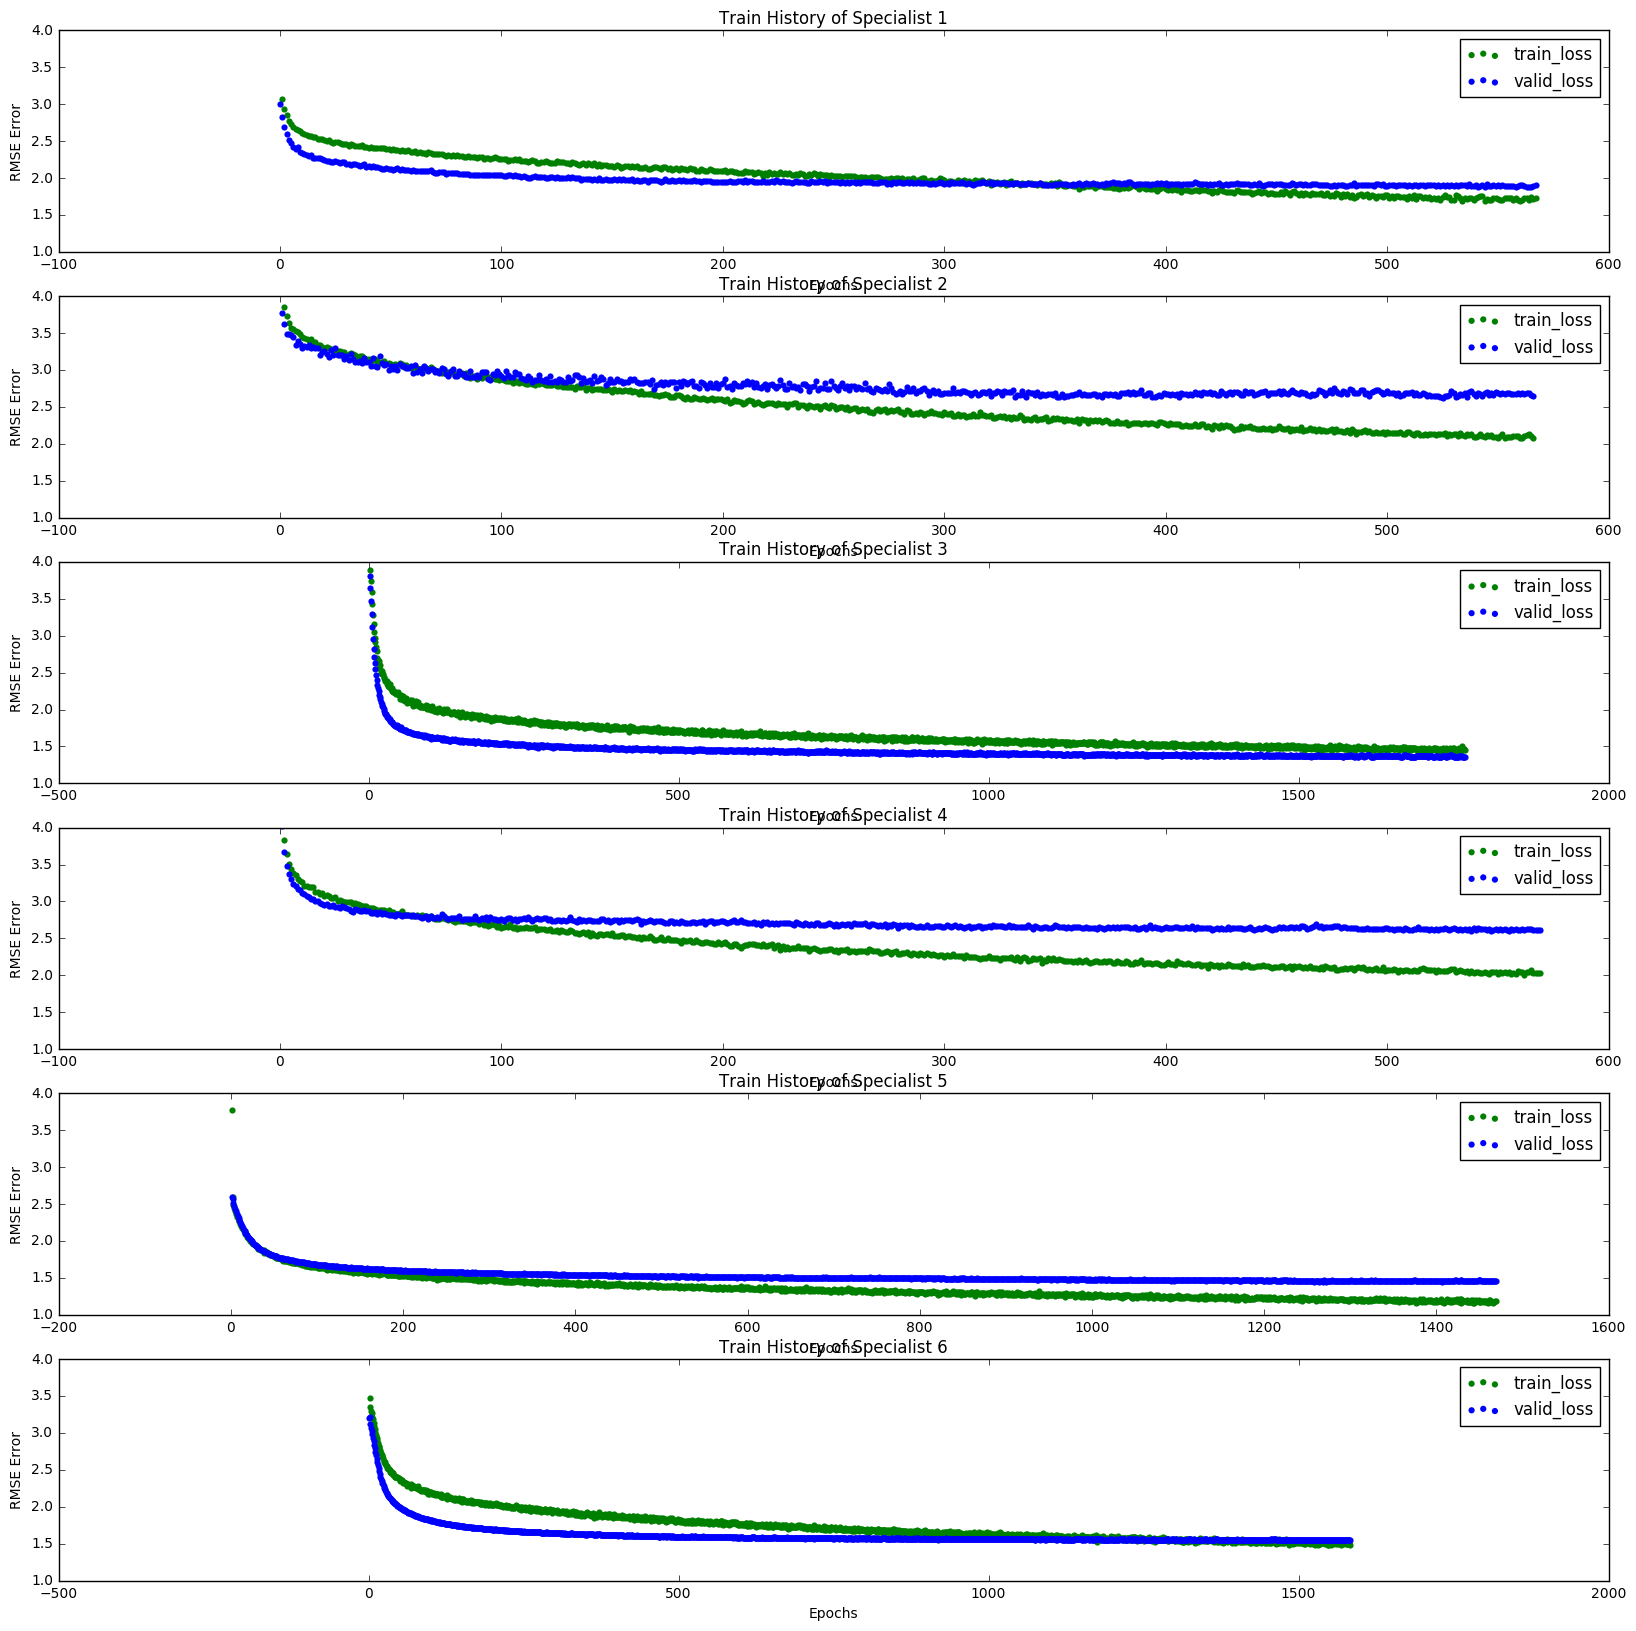

In [23]:
modelNames = ["net-specialists1.pickle","net-specialists2.pickle","net-specialists3.pickle",
          "net-specialists4.pickle","net-specialists5.pickle","net-specialists6.pickle"]
plot_loss(modelNames)

### B. Correction Of OverFitting

From the plots we can observe that in specialists 2 and 4 as the train loss decreases the validation loss remains constant which is an indication of over fitting. To correct this, we tries different dropout values for these 2 specialists till we arrived at the most optimal value

In [ ]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        kwargs=dict(dropout1_p=0.1,dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.9),
        pickle_file="net-specialists21.pickle",
        ),
    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        kwargs=dict(dropout1_p=0.1,dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.9),
        pickle_file="net-specialists41.pickle",
        )
    ]

In [ ]:
##Retraining Specialists 2 and 4
fit_specialists(fname_pretrain = 'net71.pickle', rows_fit = train_size)

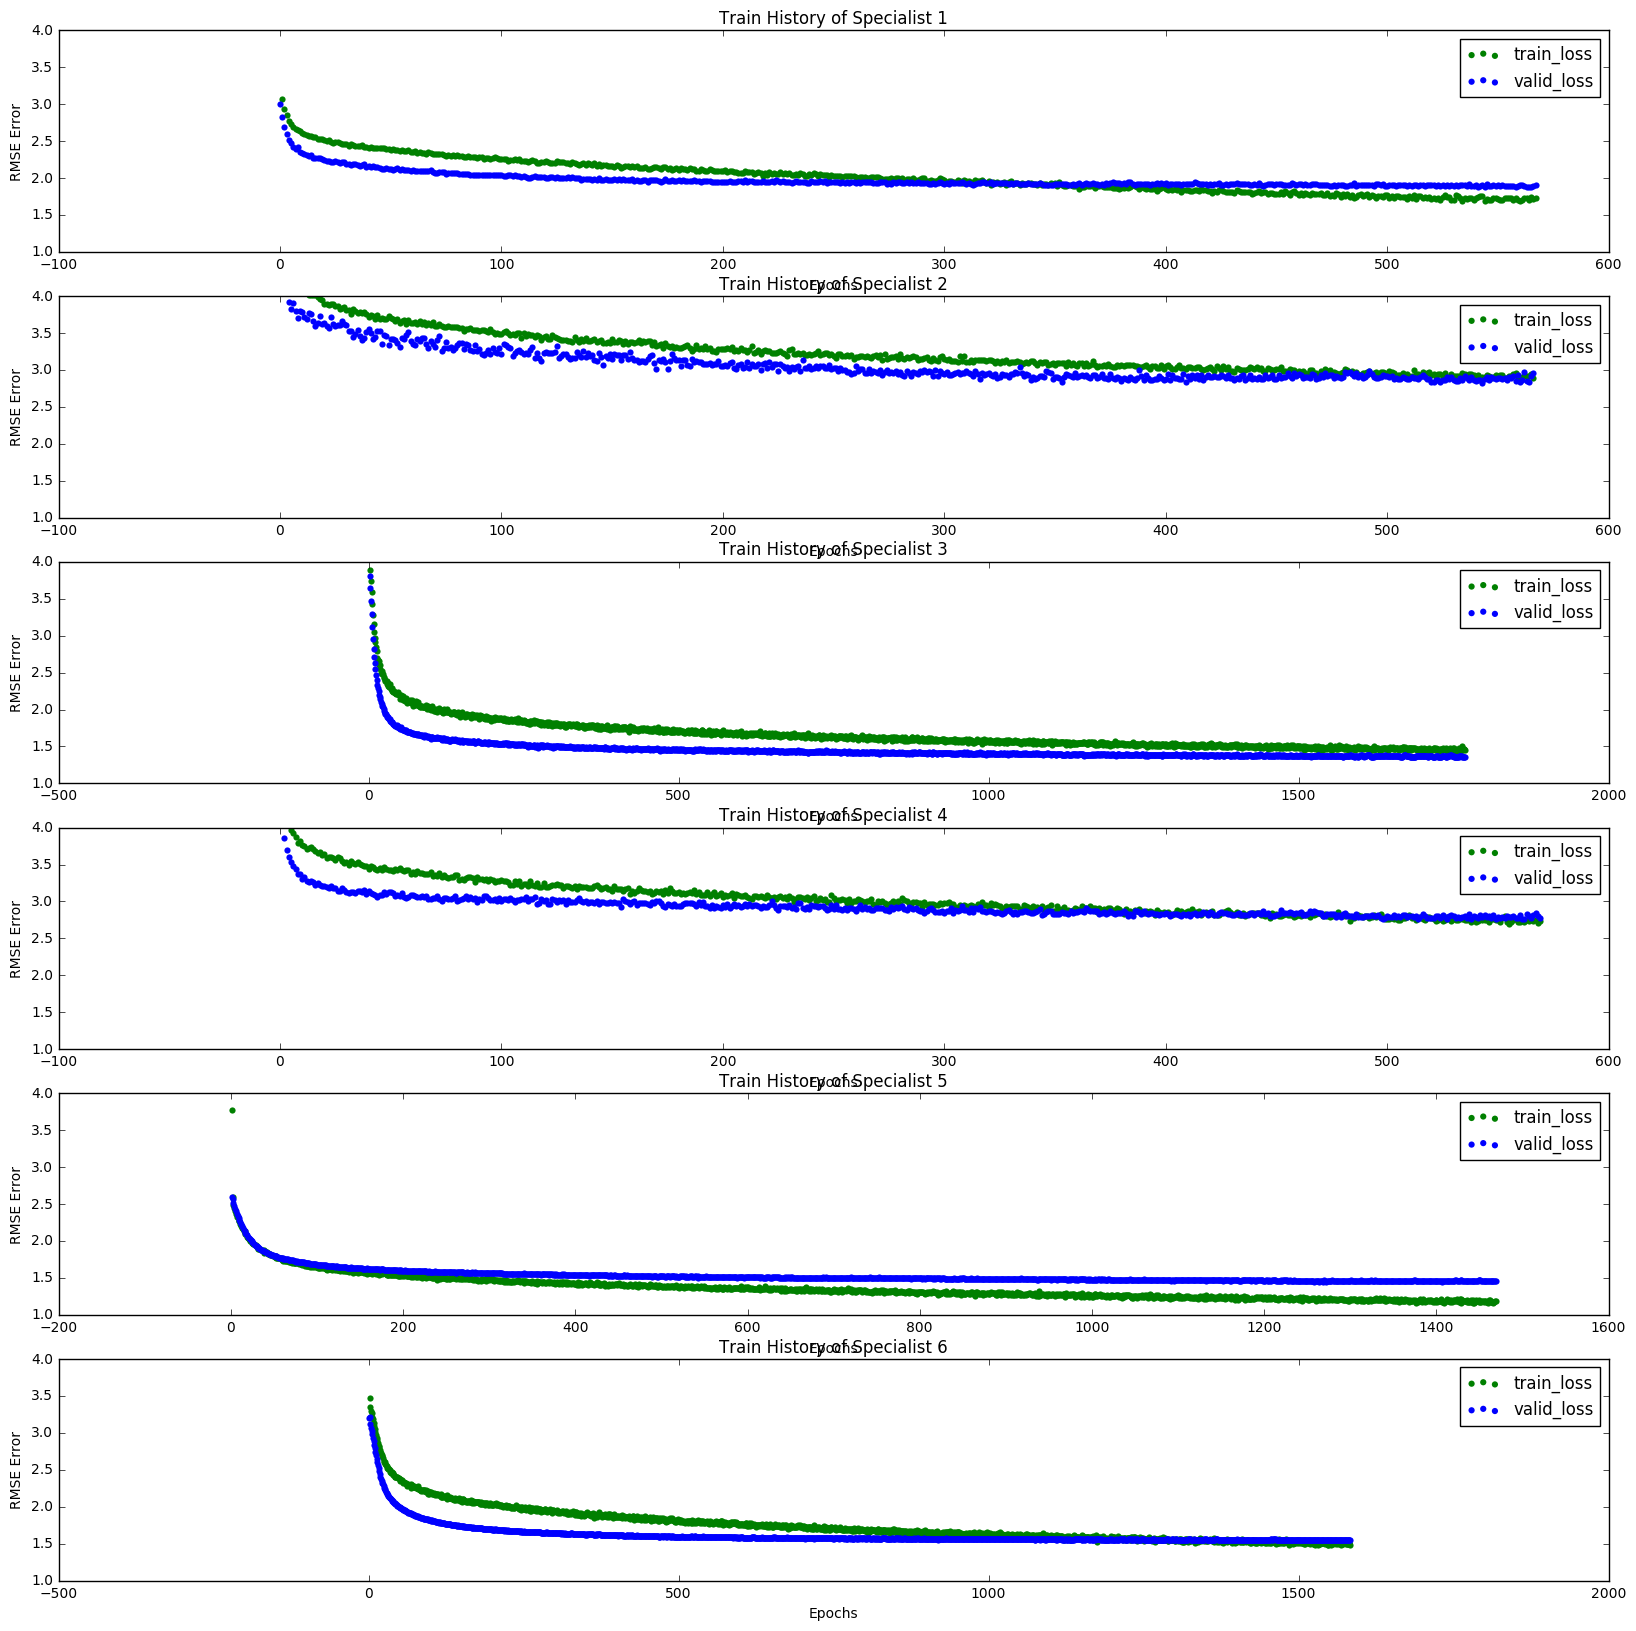

In [25]:
##Plotting loss functions after correction of overfitting
modelNames = ["net-specialists1.pickle","net-specialists21.pickle","net-specialists3.pickle",
          "net-specialists41.pickle","net-specialists5.pickle","net-specialists6.pickle"]
plot_loss(modelNames)

## 5. Citations

[1] Daniel Nouri - Using convolutional neural nets to detect facial keypoints tutorial (December 17, 2014)
http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

[2] Benjamin Bossan - Tutorial: Training convolutional neural networks with nolearn (April 4, 2016)
http://nbviewer.jupyter.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb 

[3] Nitish Srivastava et al - Dropout: A Simple Way to Prevent Neural Networks fromOverfitting (June 2014) - Journal of Machine Learning Research 15

## 6. Appendix

This section contains the main python code that is not exposed in the main Jupyter Notebook

In [ ]:
# %load 'Our_Nets/deeper_nets.py'
"""
This file defines a number of custom neural net architectures that are
deeper than the base_net defined in Daniel_Nouri's Code. This script
assumes that you have downloaded the data in a 'data' folder in the
user's home directory and that you have cloned the project repo at:
/home/ubuntu/W207_FinalProject.

AVAILABLE NETS:
    cnn1, cnn2, cnn3, cnn4, cnn5, cnn6, cnn7

USAGE:
    python deeper_nets.py fit cnn1                      (To train and pickle)
    python deeper_nets.py describe cnn1                 (To print architecture)
    python deeper_nets.py continue_training cnn1 10     (To train more epochs)
"""

# general imports
try:
    import cPickle as pickle
except ImportError:  # Python 3
    import pickle
from datetime import datetime
import os
import sys

from matplotlib import pyplot
import numpy as np
from lasagne import layers
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet, PrintLayerInfo
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import theano

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer

# Importing functions from Daniel Nouri's Code.
sys.path.append('/home/ubuntu/W207_FinalProject/') # needed to recognize DNouri module
from DNouri_Code.kfkd import float32, load, load2d, FlipBatchIterator, AdjustVariable, EarlyStopping

# Global settings
sys.setrecursionlimit(10000)  # for pickle...
np.random.seed(42)

# Global Vars
FTRAIN = '~/data/training.csv'
FTEST = '~/data/test.csv'
FLOOKUP = '~/data/IdLookupTable.csv'
FNETS = '/home/ubuntu/W207_FinalProject/Our_Nets/'

##################### THE NET ARCHITECTURES ########################

# Simple net for starting point in Introduction
cnn0 = NeuralNet(
                 layers=[
                         (layers.InputLayer, {'shape': (None, 1, 96, 96)}),
                         (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
                         (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
                         (layers.DenseLayer, {'num_units': 100}),
                         (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
                         ],
                 
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,
                 max_epochs= 1000,
                 verbose=1,
                 )

# First net 3 convo layers with pooling between
cnn1 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),


        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

# cnn1 doubled up convolutions
cnn2 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),

        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

# cnn1 trippled up convolutions
cnn3 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),

        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

# cnn1 minus last dropout layer
cnn4 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),


        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

# cnn1 doubled up convolutions without the final dropout
# NOTE: I briefly this net w/ the same 0.5 dropout from above but after
# 200 epochs it didn't look promising so I bailed.
cnn5 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),

        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

# cnn1 doubled up convolutions minus last DropoutLayer, with increasing dropout
cnn6 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),

        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.1}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.2}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.3}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=400),
        ],
    max_epochs=1000,
    verbose=1,
    )

cnn7 = NeuralNet(
    layers=[
        (layers.InputLayer, {'shape': (None, 1, 96, 96)}),

        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.1}),

        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.2}),

        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
        (layers.MaxPool2DLayer, {'pool_size': (2, 2)}),
        (layers.DropoutLayer, {'p':0.3}),

        (layers.DenseLayer, {'num_units': 1000}),
        (layers.DropoutLayer, {'p':0.5}),

        (layers.DenseLayer, {'num_units': 1000}),

        (layers.DenseLayer, {'num_units': 30, 'nonlinearity': None}),
        ],

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.95)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.95, stop=0.999),
        EarlyStopping(patience=400),
        ],
    max_epochs=500,
    verbose=1,
    )

##################### FUNCTIONS & CL SCRIPT ########################
# Function to train and picke a net
def fit(net, name='cnn'):
    X, y = load2d()
    net.fit(X, y)
    with open(name +'.pickle', 'wb') as f:
        pickle.dump(net, f, -1)

# Function to print the net architecture
def describe(net):
    net.initialize()
    showLayers = PrintLayerInfo()
    showLayers(net)

def continue_training(netname, num_epochs, resave = False):
    """
    Function to load a pickled net and train it for another num_epochs.
    """
    # load previous net - ADD CODE to get pickle filepath
    try:
        with open(FNETS + netname + '.pickle', 'rb') as f:
            p_net = pickle.load(f)
    except Exception, e:
        print('... There was an error loading ' + FNETS + netname + '.pickle')
        print('... Please check that this file exists and try again.')
        return None
    p_epochs = p_net.train_history_[-1]['epoch']
    print "... The previous net had trained {} epochs.".format(p_epochs)

    # load data, then intialize and train new net
    X, y = load2d()
    net = globals()[netname]
    net.load_params_from(p_net)
    net.max_epochs = num_epochs
    net.fit(X,y)

    if resave:
        # update train history to reflect previous net
        for i in net.train_history_:
            i['epoch'] += p_epochs
        net.train_history_ = p_net.train_history_ + net.train_history_
        # pickle the resulting file
        with open(FNETS + netname + '.pickle', 'wb') as f:
            pickle.dump(net, f, -1)

# Main script.
if __name__ == '__main__':
    if len(sys.argv) < 3:
        print(__doc__)
    elif sys.argv[1] == 'continue_training':
        # get paramters
        try:
            num_epochs = int(sys.argv[3])
        except Exception, e:
            print(__doc__)
        nname = sys.argv[2]
        msg = '... Resave {} after training? y/[n]:'.format(nname+'.pickle')
        resave = raw_input(msg).lower() in ['y', 'yes']
        # confirm to proceed
        print('... Preparing to train {} for {} additional epochs?'.format(
              nname, num_epochs))
        msg = '... Please confirm that you wish to proceed y/[n]:'
        if raw_input(msg).lower() in ['y', 'yes']:
            continue_training(nname, num_epochs, resave)
        else:
            print('... OK. Canceling training.')
    else:
        func = globals()[sys.argv[1]]
        net = globals()[sys.argv[2]]
        func(net, name=sys.argv[2])
